### Bigram Analysis

Bigram analysis of speeches was done using R because the plotting functionality of ggplot is much better. Speech text was tokenized into bigrams, and the frequency of bigrams in each speech was calculated and the top 12 were plotted. 

In [1]:
# import required packages
library(tidyverse)
library(stringr)
library(lubridate)
library(tidytext)
library(ggplot2)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“package ‘stringr’ was built under R version 3.4.3”
Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Warning message:
“package ‘tidytext’ was built under R version 3.4.4”

In [2]:
# load data
setwd("/Users/ratulesrar/Documents/Fifth Year/spring_quarter/text_mining/sotu-approval-analysis/")

sou <- read_csv("data/sou.csv")
presidents <- read_csv("data/presidents.csv")

sou <- sou %>%
  left_join(presidents)

Parsed with column specification:
cols(
  link = col_character(),
  president = col_character(),
  message = col_character(),
  date = col_date(format = ""),
  text = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“20 parsing failures.
row # A tibble: 5 x 5 col     row   col           expected actual           file expected   <int> <chr>              <chr>  <chr>          <chr> actual 1   232  text delimiter or quote      I 'data/sou.csv' file 2   232  text delimiter or quote        'data/sou.csv' row 3   232  text delimiter or quote      D 'data/sou.csv' col 4   232  text delimiter or quote        'data/sou.csv' expected 5   232  text delimiter or quote      C 'data/sou.csv'
... ................. ... ...................................................... ........ ...................................................... ...... ......................................................

In [3]:
# break text into bigrams
bigrams <- sou %>% 
  mutate(year = year(date),
         words = quanteda::ntoken(text, remove_punct = TRUE)) %>%
  filter(year > 1933) %>%
  unnest_tokens(bigram, text, token = "ngrams", n = 2) %>%
  separate(bigram, into = c("first","second"), sep = " ", remove = FALSE) %>%
  # remove stop words from tidytext package 
  anti_join(stop_words, by = c("first" = "word")) %>%
  anti_join(stop_words, by = c("second" = "word")) %>%
  filter(str_detect(first, "[a-z]"),
         str_detect(second, "[a-z]")) %>%
  group_by(president,party,date,year,words) %>%
  count(bigram) %>%
  arrange(-n)

bigram_freqs <- bigrams %>% 
  left_join(bigrams %>% 
              group_by(president,party,date,year,words) %>% 
              summarise(total = sum(n))) %>%
  mutate(percent = n/total*100) %>%
  group_by(president,party,date)

# get the top bigram for each address
top_bigrams <- bigram_freqs %>%
  top_n(1) %>%
  arrange(-percent)

top_bigram_freqs <- bigram_freqs %>%
  semi_join(top_bigrams) %>%
  ungroup() %>%
  arrange(-percent) %>%
  mutate(year = year(date),
         address = paste0(president,", ",year))

Joining, by = c("president", "party", "date", "year", "words")
Selecting by percent
Joining, by = c("president", "party", "date", "year", "words", "bigram", "n", "total", "percent")


Saving 7 x 7 in image


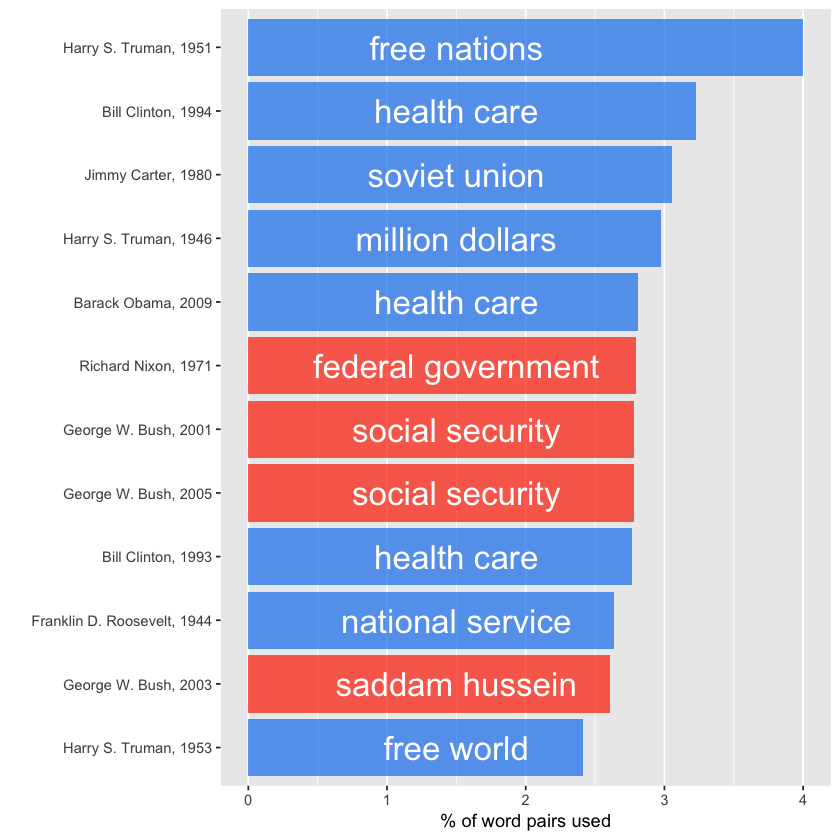

In [4]:
# some cleaning for display in chart
top_bigram_freqs$address <- gsub("William J.","Bill", top_bigram_freqs$address)

# color palette for this chart
bigram_pal <- c("#1482EE","#FF3300","#686868","#228B22","#EEC900")

# chart
ggplot(top_bigram_freqs[1:12,], aes(x=reorder(address,percent), y=percent, fill=party, label=bigram)) +
  geom_bar(stat = "identity", alpha = 0.7) +
  geom_text(aes(y = 1.5), color = "#FFFFFF", size = 7) +
  scale_fill_manual(values = bigram_pal, guide = FALSE) +
  #theme_minimal(base_size = 24, base_family = "ProximaNova-Semibold") +
  theme(panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank()) +
  xlab("") +
  ylab("% of word pairs used") +
  coord_flip()

ggsave('data/bigrams.png')